In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from time import time

n_model = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [2]:
data = pd.read_csv('../datasets/Arabic_poem_reduced.csv')

In [3]:
vocab = [' ','ء', 'آ', 'أ', 'ؤ', 'إ', 'ئ', 'ا', 'ب', 'ة', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ى', 'ي']

vocab2token = { vocab[i]:i+1    for i in range(len(vocab)) }
token2vocab = { i+1:vocab[i]    for i in range(len(vocab)) }

def sentence2tokens(s):
    return [vocab2token[c] if c in vocab else len(vocab) for c in s]

def tokens2sentence(t):
    return [token2vocab[c] for c in t]

def get_posiions_list(line):
    pos = []
    i = 1
    for c in line:
        if c == ' ':i = 1
        else:i += 1
        pos.append(i)
    return pos

special = ['َ', 'ُ', 'ِ', 'ً', 'ٌ', 'ٍ', 'َّ', 'ُّ', 'ِّ','ًّ', 'ٌّ', 'ٍّ', 'ْ','ّ']
sps_dict = {}
for i, c in enumerate(special):
    sps_dict[c] = i

In [4]:
def get_raw_sentence(sentence):

    sentence = list(sentence)
    
    S = []

    i, j = 0 ,1
    L = len(sentence)

    while i < L - 1:
        if sentence[i] == ' ':
            S.append(' ')
            i += 1
            j += 1

        else:
            S.append(sentence[i])
            if sentence[j] not in special:
                i += 1
                j += 1
            
            elif sentence[j] != 'ّ':
                i += 2
                j += 2
            
            else: # sentence[j] = 'ّ'
                if  j == L-1 or sentence[j+1] not in special: 
                    i += 2
                    j += 2
                else:
                    i += 3
                    j += 3
                    

    if i < L and not sentence[-1] in special:
        S.append(sentence[-1])

    return S

In [5]:
meters = list(data['البحر'].unique())

meter2id = {meters[i]:i for i in range(len(meters))}
id2meter = {i:meters[i] for i in range(len(meters))}

In [6]:
selected_meters = ['الطويل','المنسرح','المتقارب','الخفيف','الكامل','السريع','الوافر','البسيط','الرجز','الرمل','المجتث','المديد','الهزج','المتدارك']
not_selected    = [t for t in meters if t not in selected_meters]

In [7]:
for m in not_selected:
    data = data.drop(data[data['البحر'] == m].index)

<AxesSubplot:xlabel='البحر', ylabel='count'>

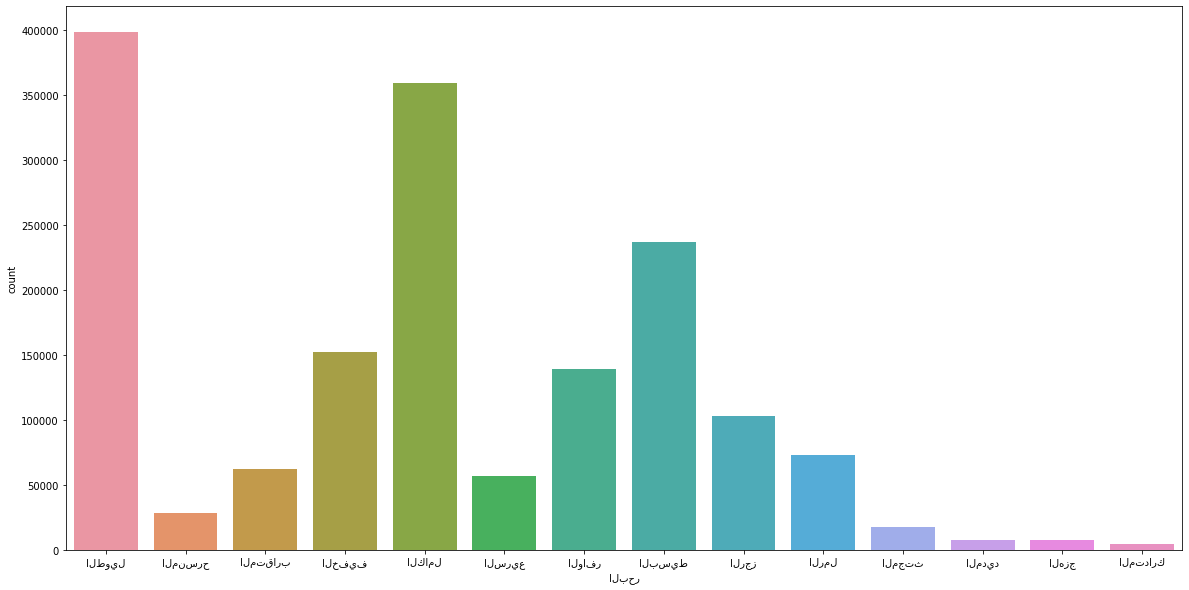

In [8]:
fig, ax = plt.subplots(figsize=(20,10))
sns.countplot(ax=ax, data=data, x='البحر')

In [9]:
meters = list(data['البحر'].unique())

meter2id = {meters[i]:i for i in range(len(meters))}
id2meter = {i:meters[i] for i in range(len(meters))}

In [10]:
class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        
        line    = self.data.iloc[idx]

        right, left, meter = line['الشطر الايمن'].strip(), line['الشطر الايسر'].strip(), line['البحر']

        right = get_raw_sentence(right)
        left  = get_raw_sentence(left )


        x = sentence2tokens(right + [' # '] + left)
        x = torch.tensor(x, dtype=torch.int64)
        meter = meter2id[meter]
        meter = torch.tensor(meter, dtype=torch.int64)

        return {
            'sentence':x,
            'meter':meter,
        }


In [11]:
def collate_fn(batch, maxlen=100):
    sentences, meters = [], []
    for line in batch:
        sentences.append(line['sentence'])
        meters.append(line['meter'].unsqueeze(0))

    
    if len(max(sentences, key=lambda x:len(x))) <= maxlen:
        T = sentences[0]
        sentences[0] = nn.ConstantPad1d((0, maxlen - T.shape[0]), 0)(T)
        
    sentences   = pad_sequence(sentences, padding_value=0 , batch_first=True)
    meters = torch.cat(meters, dim=0)
    
    return sentences, meters

In [12]:
TRAIN_BATCH_SIZE = 128

dataset = MyDataset(data)

dataloader = DataLoader(
    dataset=dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True, 
    collate_fn=collate_fn, 
    prefetch_factor=1, 
    num_workers=2
    )

In [13]:
class LstmModel(nn.Module):
    def __init__(
        self,
        emb_dim,
        vocab_size,
        output_size,
    ):
        super(LstmModel, self).__init__()
        self.vocab_size  = vocab_size
        self.output_size = output_size

        self.embdding     = nn.Embedding(num_embeddings=vocab_size, embedding_dim=emb_dim, padding_idx=0)
        self.pos_embdding = nn.Embedding(num_embeddings=15, embedding_dim=emb_dim, padding_idx=0)

        self.lstm_layer_1 = nn.LSTM(
            input_size=emb_dim,
            hidden_size=128,
            num_layers=1,
            bidirectional=True,
            batch_first=True,
        )

        self.lstm_layer_2 = nn.LSTM(
            input_size=self.lstm_layer_1.hidden_size * 2,
            hidden_size=128,
            num_layers=1,
            bidirectional=True,
            batch_first=True,
        )

        self.lstm_layer_3 = nn.LSTM(
            input_size=self.lstm_layer_2.hidden_size * 2,
            hidden_size=128,
            num_layers=1,
            bidirectional=True,
            batch_first=True,
        )


        self.fc1 = nn.Linear(self.lstm_layer_3.hidden_size * 2 , 128)
        self.fc2 = nn.Linear(128, output_size)
        

        self.dropout1 = nn.Dropout(0.5)


    def forward(self, src):

        emb = self.embdding(src)

        lstm_1_seq, (lstm_1_h, lstm1_c) = self.lstm_layer_1(emb)
        lstm_2_seq, (lstm_2_h, lstm2_c) = self.lstm_layer_2(lstm_1_seq)
        lstm_3_seq, (lstm_3_h, lstm3_c) = self.lstm_layer_3(lstm_2_seq)
        
        lstm_out = lstm_3_seq[:, -1, :]
        
        features = lstm_out
        
        out = self.dropout1(F.relu(self.fc1(features)))
        out = self.fc2(out)

        return out

In [14]:
def split_data(data, s=0.5):
    import random
    ids = list(range(len(data)))
    random.shuffle(ids)
    x = int(len(ids)*s)
    return data.iloc[ids[:x]], data.iloc[ids[x:]]

In [15]:
train_data, val_data = split_data(data)

train_dataset = MyDataset(train_data)
val_dataset   = MyDataset(val_data)

f'There are {len(train_dataset) :,} samples for training, and {len(val_dataset) :,} samples for validation testing'

'There are 823,273 samples for training, and 823,274 samples for validation testing'

In [16]:
TRAIN_BATCH_SIZE = 128

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True, 
    collate_fn=collate_fn, 
#     prefetch_factor=1, 
#     num_workers=1
    )

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=128,
    shuffle=True, 
    collate_fn=collate_fn, 
#     prefetch_factor=1, 
#     num_workers=1
    )

# Training

In [17]:
def train_step(model, src, tgt, optimizer, scheduler, loss_fn, max_norm=0.9):
    model.train()
    model.zero_grad()

    src = src.to(device)

    out = model(src)

    out = out.reshape(-1,OUTPUT_SIZE)
    tgt = tgt.reshape(-1).to(device)
    loss = loss_fn(out, tgt)

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
    optimizer.step()
    if scheduler:
        scheduler.step()

    return loss.item()

In [18]:
def eval_model(model, dataloader, loss_fn, log_steps = 5):
    model.eval()
    eval_loss = 0
    i = 0
    L_train_dataloader = len(dataloader)
    
    for src, tgt in dataloader:
        
        src = src.to(device)

        out = model(src)

        out = out.reshape(-1,OUTPUT_SIZE)
        tgt = tgt.reshape(-1).to(device)
        loss = loss_fn(out, tgt)
        eval_loss += loss.item()

        i += 1
        if i % ( L_train_dataloader / log_steps) < 1:
            print(f'        EVAL STEP: {i} / {L_train_dataloader}')

    return eval_loss / i




def calculate_accuracy(model, dataloader):
    model.eval()

    with torch.no_grad():
        a, r = 0, 0
        j = 0
        for src, tgt in dataloader:

            src = src.to(device)

            out = model(src).detach().cpu()

            out = out.reshape(-1,OUTPUT_SIZE)
            tgt = tgt.reshape(-1)

            out = torch.argmax(out, dim=-1)
            
            a += len(tgt)
            r += sum(tgt == out).item()
            
            j += 1
            
            if j % (len(dataloader) // 5) == 0:
                print(f'ACC STEP {j}/{len(dataloader)}')

    return (r / a)

In [19]:
VOCAB_SIZE  = len(vocab) + 1
OUTPUT_SIZE = len(meters)


model = LstmModel(
    128,
    VOCAB_SIZE,
    OUTPUT_SIZE).to(device)

n_model += 1


optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=-100)

In [ ]:
EPOCH = 20
log_steps = 10
L_train_dataloader = len(train_dataloader)
losses = []
eval_losses = []
lrs = []
max_val_acc = 0
val_acc = 0.94

src, tgt =  next(iter(train_dataloader))

for epoch in range(1, EPOCH+1):
    print(f'EPOCH: {epoch} START TRAINING ... ----------------------------------------------------------------------')
    epoch_loss = 0
    steps_loss = 0
    i, j = 0, 0
    s_time = time()
    # for _  in train_dataloader:
    for src, tgt in train_dataloader:
        i, j = i+1, j+1
        loss = train_step(model, src, tgt, optimizer, None, loss_fn)
        losses.append(loss)
        epoch_loss += loss
        steps_loss += loss
        if i % ( L_train_dataloader / log_steps) < 1:
            lr = optimizer.param_groups[0]['lr']
            lrs.append(lr)
            print(f'EPOCH: {epoch}    STEP: {i} / {L_train_dataloader}   STEP LOSS: {steps_loss / j:.5f}   TIME: {time() - s_time:.4f}    LR: {lr:.6f}')
            s_time = time()
            j = 0
            steps_loss = 0
    
    print('EVALUATION :')
    
    if (epoch + 1) % 2 == 0:
        val_acc = calculate_accuracy(model, val_dataloader)
    print(f'EPOCH: {epoch}    TRAINING LOSS: {epoch_loss / i:.5f}   VAL ACC: {val_acc*100:.3f}')


    if val_acc > max_val_acc:
        print(f'SAVING BEST MODEL {n_model}')
        max_val_acc = val_acc
        torch.save(model.state_dict(), f'best_lstm_model_{str(n_model)}.pt')

    print('----------------------------------------------------------------------------------------------------', end='\n\n')

In [ ]:
# torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': loss,
#             }, 'model_checkpoint')

In [20]:
model.load_state_dict(torch.load('../../models/meter_classification/meter_classification_model.pt', map_location=device))

<All keys matched successfully>

In [21]:
def get_raw_sentence(sentence):

    sentence = list(sentence)
    
    S = []

    i, j = 0 ,1
    L = len(sentence)

    while i < L - 1:
        if sentence[i] == ' ':
            S.append(' ')
            i += 1
            j += 1

        else:
            S.append(sentence[i])
            if sentence[j] not in special:
                i += 1
                j += 1
            
            elif sentence[j] != 'ّ':
                i += 2
                j += 2
            
            else: # sentence[j] = 'ّ'
                if  j == L-1 or sentence[j+1] not in special: 
                    i += 2
                    j += 2
                else:
                    i += 3
                    j += 3
                    

    if i < L and not sentence[-1] in special:
            S.append(sentence[-1])

    return S


In [47]:
kamil = """صرمَت ظليمةُ خُلّتي ومراسلي
وتباعدَت ضنّاً بزاد الراحلِ
جهلاً وما تدري ظليمة أَنّتي
قد أستقلُّ بصرم غير الواصِلِ
ذُلُلٌ ركابي حيثُ شئتُ مُشَيّعي
أنّي أروعُ قطا المكانِ الغافلِ
أَظليمَ ما يُدريكِ رُبّة خُلّةٍ
حسنٌ ترغَّمُها كَظَبي الحائلِ
قد بِتُ مالكَها وشاربَ قهوةٍ
درياقةٍ روّيت منها وَاغلى
بيضاءَ صافيةٍ يُرى مِن دونه
قعرُ الأناء يُضيء وجه الناهلِ
وسرابَ هاجِرةٍ قطعتُ إذا جرى
فوقَ الأكام بذاتِ لونٍ باذلِ""".strip().split('\n')

khafif = """إِنَّ فينا القيان يَعزِفنَ بالدُ
فِ لفتياننا وعيشاً رخيّا
يتبارَين في النَعيم ويصُببنَ
خِلالَ القرونِ مِسكاً ذكيّا
إِنما هُمهنّ أَن يَتحلَّين سُ
موطاً وسُنبلاً فارسياً
من سموط المرجان فُصِّلَ بالشّذ
رِ فأَحسِن بحليِهنَّ حُليّا
 وفتىً يضربُ الكتيبةَ بالسَيفِ
اذا كانتِ السيوفُ عِصيا
 إِننا لا نُسَرُّ في غيرِ نجدٍ
إِنَّ فينا بها فتىً خزرجيّا
 يدفعُ الضَيمَ والظُلامةَ عنه
فَتَجافي عنه لنا يامَنيّا""".strip().split('\n')

tawil = """عاوَدَ عَينَي نَصبُهَا وَغُرورُها
أهمُّ عَناهَا أمْ قَذَاها يَعُورُهَا
أم الدار أَمسَت قَد تَعَفَّت كأَنَّهَ
زَبُورُ يَمَانٍ نَقَّشَتهُ سُطُورُهَا
ذَكَرَتُ بِها هِنداً وأترابَها الأُلَى
بِهَا يُكذَبُ الوَاشي ويُعصَى أميرُهَا
بِأَغْزرَ مِنّي عَبرةً إِذَ رَأيتُهَا
يحَثُ بِهَا قَبلَ الصَّبَاحِ بَعيرُهَا
أَلَم يَأتِ هِنداً كَيفَما صُنعُ قَومِه
بَني عَامِر إِذا جَاءَ يَسعَى نَذِيرُهَا
فَقَالُوا لَنَا إِنَّا نُحِبُّ لِقَاءَكُم
وَأَنَّا نُحَيِّيي أرضَكُم ونَزُورُها
فَقُلنَا إِذن لاَ نَنكُلُ الدَّهرَ عنكُمُ
بِصُمِّ القَنَا اللاَّئِي الدِّمَاءَ تُميرُها
فَلاَ غَروَ أَنَّ الخَيلَ تَنحَطُ في القَنَا
تَمَطَّرُ مِن تَحتِ العوالي ذُكُورها""".strip().split('\n')

In [39]:
model.eval()

for poem in [kamil, khafif, tawil]:

    for i in range(len(poem) // 2):
        right = poem[i*2].strip()
        left  = poem[i*2 + 1].strip()
            
        right = get_raw_sentence(right)
        left  = get_raw_sentence(left )
        
        s = ''.join(right) + ' # ' + ''.join(left)
        
        x = sentence2tokens(s)
        x = torch.tensor(x, dtype=torch.int64)
        
        x = nn.ConstantPad1d((0, 100 - x.shape[0]), 0)(x).unsqueeze(0).to(device)
        
        out = torch.argmax(model(x), dim=-1).item()
        print(id2meter[out])

    print('\n')

البسيط
البسيط
البسيط
البسيط
البسيط
البسيط
البسيط
البسيط


